# Topic Modeling Using Distributed Word Embeddings
Notebook version of https://github.com/rsrandhawa/Vec2Topic code, based on the article 
"Topic Modeling Using Distributed Word Embeddings" by R. S. Randhawa, P. Jain, and G. Madan. 
Use wikipedia data as knowledge base (the Simple English Wikipedia for testing and English 
Wikipedia for real) as well as enron data for the user generated content.

## Import standard and machine-learning libraries

In [1]:
import logging, re, os, bz2
from collections import Counter
from operator import itemgetter
import itertools

In [2]:
import fastcluster
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob, Word
import numpy as np
import scipy as sp
import gensim
from gensim.corpora import WikiCorpus

In [3]:
import unicodecsv as csv
import pandas as pd
from bokeh.charts import Scatter, output_notebook, show

## Base data directory and logging.

In [4]:
data_directory = '/data/simplewiki/'

In [5]:
from imp import reload
reload(logging)

LOG_FILENAME = data_directory + 'vec2topic.log'
#logging.basicConfig(filename=LOG_FILENAME,level=logging.INFO)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s %(message)s',"%b-%d-%Y %H:%M:%S")
logger.handlers[0].setFormatter(formatter)

## Global knowledge vectors -- wikipedia

The gensim package has examples of processing wikipedia dumps as well as streaming corpus implementation. The article just glosses over these steps and the sample github code grabs an undocumented data set from the authors drobbox account. In the cells below we rely on word2vec:
<pre>
git clone https://github.com/tmikolov/word2vec.git
</pre>
Also, in order to compute the t-sne embeddings with a c-language program, used bhtsne:
<pre>
git clone https://github.com/lvdmaaten/bhtsne.git
</pre>
When using jupyter-gallery docker image, usually install these in the /root directory. Hardwired into this notebook. 

TODO: 
* Parse the wikipedia dump name and use it as the prefix for the other intermediate files.
* Download a wikipedia dump if it doesn't already exist.
* Make things work for other languages (hundreds of wikipedias).
* Check that WikiCorpus does lowercase each word.
* Handle stopwords and substitution lists consistently.
* Stem global and local data sets.
* Check to see any value of using textblob over nltk.

### List of intermediate files.

In [6]:
knowledge_base = 'simplewiki-20160820-pages-articles.xml.bz2'
knowledge_base_prefix = 'simplewiki'
knowledge_base_text = data_directory + knowledge_base_prefix + '_text.txt'
knowledge_base_phrases = data_directory + knowledge_base_prefix + '_phrases.txt'
knowledge_base_vector_dimension = 300    # Word vector dimensionality for knowledge base.
knowledge_base_vectors = data_directory + knowledge_base_prefix + '_vec.txt'
knowledge_base_vectors_tsne = data_directory + knowledge_base_prefix + '_vec_tsne.txt'
knowledge_base_vocab = data_directory + knowledge_base_prefix + '_vocab.txt'

local_content = 'ken_lay.txt'
local_content_prefix = 'ken_lay'
local_content_text = data_directory + local_content_prefix + '_text.txt'
local_content_phrases = data_directory + local_content_prefix + '_phrases.txt'
local_content_vector_dimension = 25
local_content_vectors = data_directory + local_content_prefix + '_vec.txt'
local_content_vectors_tsne = data_directory + local_content_prefix + '_vec_tsne.txt'
local_content_vocab = data_directory + local_content_prefix + '_vocab.txt'

combined_vectors = data_directory + local_content_prefix + '_combined_vectors.txt'
combined_vectors_tsne = data_directory + local_content_prefix + '_combined_vectors_tsne.txt'

### Process wikipedia dump
First download the wikipedia dump and place it in the data directory before running this notebook. The cell below will use the gensim class WikiCorpus to strip the wikipedia markup and store each article as one line of the output text file. Only do these computations once if possible.

In [7]:
try:
    fp = open(knowledge_base_text,'r')
    fp.close()
    logger.info('Knowledge base %s already on disk.', knowledge_base_text)
except Exception as ex:
    space = ' '
    i = 0
    output = open(knowledge_base_text, 'w')
    logger.info('Processing knowledge base %s', knowledge_base)
    wiki = WikiCorpus(data_directory + knowledge_base, lemmatize=False, dictionary={})
    for text in wiki.get_texts():
        output.write(space.join(text) + "\n")
        i = i + 1
        if (i % 10000 == 0):
            logger.info("Saved " + str(i) + " articles")
    output.close()
    logger.info("Finished Saved " + str(i) + " articles")

Sep-10-2016 19:44:32 Knowledge base /data/simplewiki/simplewiki_text.txt already on disk.


### Detect phrases in wikipedia dump
Use the google word2phrase code to identify common phrases (such as San Diego) in the text (as token san_diego).

In [8]:
cmd = '/root/word2vec/word2phrase'
arguments = ' -train ' + knowledge_base_text  + ' -output ' + knowledge_base_phrases + ' -threshold 100 -debug 2'
try:
    fp = open(knowledge_base_phrases,'r')
    fp.close()
    logger.info('Phrases %s already exist.', knowledge_base_phrases)
except Exception as ex:
    for line in os.popen(cmd + arguments):
        logger.info(line.strip())

Sep-10-2016 19:44:44 Phrases /data/simplewiki/simplewiki_phrases.txt already exist.


### Compute word vectors for knowledge base

In [9]:
cmd = '/root/word2vec/word2vec'
arguments = ' -train ' + knowledge_base_phrases + ' -output ' + knowledge_base_vectors
arguments += ' -size ' + str(knowledge_base_vector_dimension) + ' -window 5 -hs 1 -threads 12 -binary 0 -cbow 0'
arguments += ' -save-vocab ' + knowledge_base_vocab + ' -sample 1e-3 -min-count 0'
try:
    fp = open(knowledge_base_vectors,'r')
    fp.close() 
    logger.info('Knowledge vectors %s already exist.', knowledge_base_vectors)  
except Exception as ex:
    for line in os.popen(cmd + arguments):
        logger.info(line.strip())
        
model_wiki_vec = gensim.models.Word2Vec.load_word2vec_format(knowledge_base_vectors, binary=False)

Sep-10-2016 19:44:52 Knowledge vectors /data/simplewiki/simplewiki_vec.txt already exist.


Simple test to see if the phrase detection came out ok.

In [10]:
print u'los_angeles' in model_wiki_vec
print u'business' in model_wiki_vec

True
True


Create a counter to keep track of the knowledge base vocabulary. Later the sample code uses this to find the vocabulary in common between the knowledge base and the user generated data. Try to process both data sets in the same way.

In [11]:
wiki_exist = Counter()
with open(knowledge_base_vocab) as vocab:
    for line in vocab:
        w = line.split()[0]
        c = line.split()[1].strip()
        wiki_exist[w] = c
model_wiki_vocab_lowercase = wiki_exist.keys()

In [12]:
logger.info('los_angeles: %s', wiki_exist[u'los_angeles'])
logger.info('angeles: %s', wiki_exist[u'angeles'])
logger.info('los: %s', wiki_exist[u'los'])
logger.info('san_diego: %s', wiki_exist[u'san_diego'])
logger.info('o_k: %s', wiki_exist[u'o_k'])
logger.info('ok: %s', wiki_exist[u'ok'])

Sep-10-2016 19:47:33 los_angeles: 3544
Sep-10-2016 19:47:33 angeles: 77
Sep-10-2016 19:47:33 los: 567
Sep-10-2016 19:47:33 san_diego: 657
Sep-10-2016 19:47:33 o_k: 0
Sep-10-2016 19:47:33 ok: 172


### Project knowledge base vectors into 2 dimensions.

In [ ]:
!cp /data/simplewiki/simplewiki_vec.txt /data/simplewiki/tmp
!sed -i -e "1d" /data/simplewiki/tmp
!awk -F' ' '{$1="";print $0}' /data/simplewiki/tmp > /data/simplewiki/tmp2
!sed 's/^ //' /data/simplewiki/tmp2 > /data/simplewiki/tmp 
!sed -i 's/ /\t/g' /data/simplewiki/tmp

In [ ]:
#!/root/bhtsne/bhtsne.py -i /data/simplewiki/tmp -o /data/simplewiki/simplewiki_vec_tsne.txt -d 2 -v

In [13]:
output_notebook()

Loading BokehJS ...

In [ ]:
reader = csv.reader(open(knowledge_base_vectors_tsne,'r'), delimiter='\t')
count = 0
X_full = []
for row in reader:
    if False and count >= 10000:
        break
    X_full.append(np.array([float(p) for p in row]))
    count += 1

In [ ]:
df = pd.DataFrame(X_full, columns=['x','y'])

In [ ]:
df.tail()

In [ ]:
p = Scatter(df, x='x', y='y', color='blue')
show(p)

## User content vectors -- Enron

In [14]:
def cleanupContent(inputString,logger,stopwords_path=[]):
        email_pattern = re.compile("[\w\.-]+@[\w\.-]+")
        try:
                inputString = unicode(inputString, errors='ignore')
        except:
                logger.info('unicode error')
        outputString = email_pattern.sub('', inputString)
        outputString=re.sub('[^\x00-\x7F]+',' ', outputString) #remove non-ascii
        outputString=re.sub('\\r',' ',outputString)
        outputString=re.sub('\\n','. ',outputString)
        outputString=re.sub('\\t',' ',outputString)
        outputString = re.sub(r"(?:\@|https?\://)\S+", " ", outputString)
#remove URLS and @xyz
        outputString=re.sub('\'','',outputString)

        outputString = re.sub('\d*.\d+',' ',outputString)
        outputString = re.sub('[.]{2,}', '.', outputString) #replace consecutive . with single .
        outputString = re.sub('\d+.\d+', ' ', outputString) #replace consecutive x.xx with space
        outputString= re.sub('[~/<>()_=-]', ' ', outputString)
        outputString=re.sub('\"',' ',outputString)
        outputString=re.sub('[,:\*!#%/$+\^]', '', outputString) #strip punct
        outputString=re.sub('[`\[\]\{\}\|]', ' ', outputString) #strip punct
        outputString=re.sub(r'\\',' ',outputString)
        outputString=re.sub(r'\b\d+\b',' ',outputString)  #remove numbers that are words
        outputString=re.sub(' +',' ',outputString)
        outputSentences=nltk.sent_tokenize(outputString)


        if stopwords_path is not None:
            logger.info("Using stop words")
            with open(stopwords_path,'rb') as f:
                stop=f.readlines()
            f.close()
            stop=set([re.sub('[^\w]','',w) for w in stop])
            outputSentences=[' '.join([x for x in w.split() if x not in stop]) for w in outputSentences if len(w)>1]
        else:
            outputSentences=[' '.join(w.split()) for w in outputSentences if len(w)>1]

        logger.info("Sentences: %d" %(len(outputSentences)))
        return outputSentences

In [15]:
stopwords_path = '/root/notebooks/notebooks/wikimodel/stopwords.txt'
text=open(local_content_text,'rb').readlines()
text=[' '.join(text)]
inpContent=cleanupContent(' '.join(text),logger,stopwords_path)
logger.info('%s %s', len(inpContent), inpContent[0:2])

Sep-10-2016 19:48:00 Using stop words
Sep-10-2016 19:48:00 Sentences: 52301
Sep-10-2016 19:48:00 52301 [u'attend meetings.', u'reinartz.']


In [16]:
local_vec_threshold=10000
inpContent=[re.sub(r'[^\w]',' ',temp) for temp in inpContent]
logger.info('%s', inpContent[0:2])

Sep-10-2016 19:48:06 [u'attend meetings ', u'reinartz ']


In [17]:
#lemmatize mails
wordnet_lemmatizer=WordNetLemmatizer()
sentences_lem=[[wordnet_lemmatizer.lemmatize(w) for w in X.split()] for X in inpContent]
sentences_lem=[[w for w in X.split()] for X in inpContent]
sentences_lem=[[w.lower() for w in _] for _ in sentences_lem]
logger.info(sentences_lem[0:2])

flat_sent=[w for _ in sentences_lem for w in _]
logger.info(flat_sent[0:4])
word_freq=Counter(flat_sent)
num_words=len(flat_sent)
logger.info('Num of words: %d' %num_words)
if num_words<100:
    logger.info('Error, too few words!')
min_count=min(5,max(2,np.percentile(word_freq.values(),q=50))) #10percentile freq

logger.info("Min count= %d" %min_count)

Sep-10-2016 19:48:14 [[u'attend', u'meetings'], [u'reinartz']]
Sep-10-2016 19:48:15 [u'attend', u'meetings', u'reinartz', u'done']
Sep-10-2016 19:48:15 Num of words: 479019
Sep-10-2016 19:48:15 Min count= 3


In [18]:
with open(data_directory + local_content_prefix + '_text_clean.txt','w') as fp:
    writer = csv.writer(fp)
    for row in sentences_lem: writer.writerow([' '.join(row)])

In [19]:
' '.join(sentences_lem[3411][:5])

u'talking naming opportunities ymcas consideration'

In [20]:
#bigrams
bigram=gensim.models.phrases.Phrases(sentences_lem,min_count=1,threshold=1)

sentences_bigrams=list(bigram[sentences_lem])
bigram_list=list(set([w for temp in sentences_bigrams for w in temp if '_' in w]))
bigram_joined=[re.sub('_','',w) for w in bigram_list]

In [21]:
u'hat' in wiki_exist

True

In [22]:
#join bigrams that are also used as unigrams
#sentences_bigrams = sentences_lem
words=[w for _ in sentences_bigrams for w in _]
logger.info(u'san_francisco' in words)
logger.info('%s %s', len(words),words[0:2])
bigram_freq=Counter(words)
logger.info('los_angeles: %s', bigram_freq[u'los_angeles'])
logger.info('angeles: %s', bigram_freq[u'angeles'])
logger.info('los: %s', bigram_freq[u'los'])
logger.info('san_diego: %s', bigram_freq[u'san_diego'])
logger.info('o_k: %s', bigram_freq[u'o_k'])
logger.info('ok: %s', bigram_freq[u'ok'])
to_join=[bigram_list[w] for w in xrange(len(bigram_list)) if bigram_freq[bigram_joined[w]]>0]
logger.info(to_join)
wiki_bigram_word_common=set([w for w in set(words) if wiki_exist[w]])
logger.info('%s',len(wiki_bigram_word_common))

Sep-10-2016 19:48:26 False
Sep-10-2016 19:48:26 292065 [u'attend_meetings', u'reinartz']
Sep-10-2016 19:48:26 los_angeles: 60
Sep-10-2016 19:48:26 angeles: 0
Sep-10-2016 19:48:26 los: 2
Sep-10-2016 19:48:26 san_diego: 0
Sep-10-2016 19:48:26 o_k: 14
Sep-10-2016 19:48:26 ok: 2
Sep-10-2016 19:48:26 [u'ma_rket', u'i_d', u'i_t', u'policy_makers', u'imp_ossible', u'voice_mails', u'n_y', u'ph_d', u'impl_ementation', u'announ_ced', u'e_c', u'ma_ke', u'understand_ing', u'multi_lingual', u'bu_siness', u'a_v', u'a_s', u'a_m', u'appr_oaches', u'wid_e', u'busi_ness', u'pub_lic', u'third_party', u'sys_tems', u'jp_morgan', u'n_w', u'actio_ns', u'g_a', u'net_works', u'se_nior', u'roll_over', u'cash_flows', u'commiss_ion', u'avenue_s', u'energy_institute', u'wh_ich', u'possess_es', u'good_bye', u'informat_ion', u'lunch_time', u'sty_le', u'ho_uston', u'turn_around', u'sta_tes', u'rockefell_er', u'syste_ms', u'front_line', u'fo_ur', u'voice_mail', u'sho_uld', u'revolu_tion', u'ne_ws', u'subs_equent', u'w

In [23]:
u'los_angeles' in wiki_bigram_word_common

True

In [24]:
sentences_bigrammed_temp=[]

#split bigrams not in wiki

for sent in sentences_bigrams:
        new_sent=[]
        for w in sent:
            if '_' not in w:
                new_sent.append(w)
            elif w in to_join:
                    new_sent.append(re.sub('_','',w))
            elif w in wiki_bigram_word_common:
                new_sent.append(w)
            else:
                new_w=re.sub('_',' ',w)
                new_w1=new_w.partition(' ')[0]
                new_w2=new_w.partition(' ')[2]
                new_sent.append(new_w1)
                new_sent.append(new_w2)
        sentences_bigrammed_temp.append(new_sent)
sentences_bigrammed=sentences_bigrammed_temp

In [25]:
logger.info("Extracting Nouns")

sentences_nouns = []

for sent in sentences_bigrammed:
    nouns=[]
    blob=TextBlob(' '.join(sent))
    for word,tag in blob.tags:
        if tag in ['NN','NNP','NNS','NNPS']:
            nouns.append(word)
    sentences_nouns.append(nouns)

if num_words<local_vec_threshold:
    logger.info('Using Wiki Vecs Only')
    local_vec=False
    iterations=1 #for gensim.word2vec, building vocabulary
else:
    logger.info('Using Local and Wiki Vecs')
    local_vec=True
    iterations=50 #for gensim.word2vec training

Sep-10-2016 19:48:42 Extracting Nouns
Sep-10-2016 19:49:32 Using Local and Wiki Vecs


In [26]:
logger.info(len(sentences_bigrammed))

Sep-10-2016 19:49:34 52301


In [27]:
flat_nouns=[w for _ in sentences_nouns for w in _]
[(i,w) for i,temp in enumerate(sentences_nouns) for w in temp if u'_' in w]

[(32, u'cultural_diversity'),
 (34, u'houston_rockets'),
 (71, u'human_resources'),
 (156, u'streaming_media'),
 (234, u'street_greenwich'),
 (235, u'greenwich_street'),
 (283, u'advertising_campaign'),
 (303, u'north_america'),
 (312, u'greatest_extent'),
 (327, u'public_utilities'),
 (331, u'extremely_difficult'),
 (365, u'suggested_amendments'),
 (369, u'enormous_amount'),
 (374, u'software_package'),
 (384, u'service_providers'),
 (412, u'lined_up'),
 (526, u'dear_mr'),
 (587, u'houston_tx'),
 (677, u'digital_divide'),
 (690, u'dear_mr'),
 (728, u'dear_mr'),
 (730, u'motor_company'),
 (739, u'cell_phone'),
 (742, u'natural_resources'),
 (751, u'energy_conservation'),
 (754, u'natural_resources'),
 (754, u'energy_conservation'),
 (757, u'energy_consumption'),
 (758, u'energy_conservation'),
 (759, u'tokyo_japan'),
 (772, u'call_me'),
 (887, u'buenos_aires'),
 (895, u'great_deal'),
 (900, u'dear_mr'),
 (933, u'hotel_rooms'),
 (978, u'telephone_call'),
 (1003, u'great_deal'),
 (1038, 

In [28]:
start = 3834
[' '.join(sent) for sent in sentences_bigrammed[start:start+2]]

[u'enrons perspective niche market enron helping organize educational_institutions bandwidth exploit asset',
 u'thoughts suggestions greatly appreciated']

In [29]:
writer = csv.writer(open(local_content_phrases,'w'))
for sent in sentences_bigrammed:
    writer.writerow([' '.join(sent)])

In [30]:
cmd = '/root/word2vec/word2vec'
arguments = ' -train ' + local_content_phrases + ' -output ' + local_content_vectors
arguments += ' -size ' + str(local_content_vector_dimension) + ' -window 5 -hs 1 -threads 12 -binary 0 -cbow 0'
arguments += ' -save-vocab ' + local_content_vocab + ' -sample 1e-3 -min-count 0'
try:
    fp = open(local_content_vectors,'r')
    fp.close() 
    logger.info('Local content vectors %s already exist.', local_content_vectors)  
except Exception as ex:
    for line in os.popen(cmd + arguments):
        logger.info(line.strip())
        
model_w = gensim.models.Word2Vec.load_word2vec_format(local_content_vectors, binary=False)

Sep-10-2016 19:50:33 Starting training using file /data/simplewiki/ken_lay_phrases.txt
Vocab size: 24110
Sep-10-2016 19:50:33 Words in train file: 521115
Alpha: 0.000125  Progress: 99.88%  Words/thread/sec: 498663.56k


In [31]:
logger.info('los_angeles: %s', model_w[u'los_angeles'])
logger.info('angeles: %s', model_w[u'angeles'])
logger.info('los: %s', model_w[u'los'])
#logger.info('san_diego: %s', model_w[u'san_diego'])
#logger.info('o_k: %s', model_w[u'o_k'])
logger.info('ok: %s', model_w[u'ok'])

Sep-10-2016 19:50:54 los_angeles: [ 0.32753599 -0.34076801  0.28299299 -0.052943    0.083084   -0.19305301
 -0.36351901 -0.111305    0.44353601 -0.13354801  0.70286399  0.29160601
  0.42871001  0.422304   -0.38281801  1.07354105  0.64852202 -0.060501
 -0.188968    0.415373   -0.47235799 -0.40346301  0.088074   -0.406546
  0.05394   ]
Sep-10-2016 19:50:54 angeles: [ 0.59544498 -0.67960697  1.10030603  0.29673299  0.46122399 -0.054878
 -0.29004201 -0.283117    0.88891202  0.093402    1.92799497  0.59022701
  0.035687    0.58481503 -1.12759399  0.64130503  0.542427   -0.438889
  0.67150998 -0.16007499 -0.70163798  0.81697297  0.44550899 -0.29309201
 -0.204895  ]
Sep-10-2016 19:50:54 los: [ 0.65374702 -0.95876497  0.93447399  0.614169    0.247171   -0.143828
 -0.136733    0.30974099  0.39544499 -0.381661    1.36559796  0.56775099
 -0.24154     0.585495   -0.873514    0.51779503  0.137969   -0.31743899
  0.63925701  0.095173   -0.83648401  0.1612      0.60658699 -0.39623901
 -0.321529  ]
Se

In [ ]:
!rm /data/simplewiki/tmp /data/simplewiki/tmp2
!cp /data/simplewiki/ken_lay_vec.txt /data/simplewiki/tmp
!sed -i -e "1d" /data/simplewiki/tmp
!awk -F' ' '{$1="";print $0}' /data/simplewiki/tmp > /data/simplewiki/tmp2
!sed 's/^ //' /data/simplewiki/tmp2 > /data/simplewiki/tmp 
!sed -i 's/ /\t/g' /data/simplewiki/tmp

In [ ]:
!/root/bhtsne/bhtsne.py -i /data/simplewiki/tmp -o /data/simplewiki/ken_lay_vec_tsne.txt -d 2 -v

In [ ]:
reader = csv.reader(open(local_content_vectors_tsne,'r'), delimiter='\t')
count = 0
X_full = []
for row in reader:
    if False and count >= 10000:
        break
    X_full.append(np.array([float(p) for p in row]))
    count += 1

In [ ]:
df = pd.DataFrame(X_full, columns=['x','y'])

In [ ]:
df.tail()

In [ ]:
p = Scatter(df, x='x', y='y', color='blue')
show(p)

In [32]:
logger.info('Creating word vecs')

words=[w for text in sentences_nouns for w in text]
Vocab=set(words)

model_comb={}
model_comb_vocab=[]

if local_vec:
    common_vocab=set(model_wiki_vocab_lowercase).intersection(model_w.vocab).intersection(Vocab)
else:
    common_vocab=set(model_wiki_vocab_lowercase).intersection(model_w.vocab).intersection(Vocab) ## ERROR? RN

for w in common_vocab:
    if len(w)>2:
        if local_vec:
            model_comb[w]=np.array(np.concatenate((model_wiki_vec[str(w)],model_w[w])))
        else:
            model_comb[w]=model_wiki_vec[str(w)]
        model_comb_vocab.append(w)

sentences=sentences_bigrammed

Sep-10-2016 19:51:06 Creating word vecs


In [33]:
writer = csv.writer(open(combined_vectors,'w'),delimiter='\t')
for k in model_comb.keys():
    writer.writerow(model_comb[k])

In [34]:
combined_vectors

'/data/simplewiki/ken_lay_combined_vectors.txt'

In [35]:
!/root/bhtsne/bhtsne.py -i /data/simplewiki/ken_lay_combined_vectors.txt -o /data/simplewiki/ken_lay_combined_vectors_tsne.txt -d 2 -v

Read the 12659 x 50 data matrix successfully!
Using current time as random seed...
Using no_dims = 2, perplexity = 50.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 0 of 12659
 - point 10000 of 12659
Input similarities computed in 0.00 seconds (sparsity = 0.021000)!
Learning embedding...
Iteration 50: error is 90.704610 (50 iterations in 0.00 seconds)
Iteration 100: error is 90.704595 (50 iterations in 0.18 seconds)
Iteration 150: error is 89.254580 (50 iterations in 0.00 seconds)
Iteration 200: error is 89.167356 (50 iterations in 0.00 seconds)
Iteration 250: error is 4.945760 (50 iterations in 0.00 seconds)
Iteration 300: error is 3.700357 (50 iterations in 0.00 seconds)
Iteration 350: error is 3.392679 (50 iterations in 0.00 seconds)
Iteration 400: error is 3.244776 (50 iterations in 0.00 seconds)
Iteration 450: error is 3.153807 (50 iterations in 0.00 seconds)
Iteration 500: error is 3.090740 (50 iterations in 4.24 seconds)
Iteration 550: err

In [36]:
reader = csv.reader(open(combined_vectors_tsne), delimiter='\t')
count = 0
X_full = []
for row in reader:
    if False and count >= 10000:
        break
    X_full.append(np.array([float(p) for p in row]))
    count += 1

In [37]:
df = pd.DataFrame(X_full, columns=['x','y'])

In [38]:
df.tail()

,x,y
12654,-6.271323,4.454396
12655,-25.283155,-5.197128
12656,26.233863,2.918912
12657,-15.380154,-0.088640
12658,-17.232757,11.717243


In [39]:
p = Scatter(df, x='x', y='y', color='blue')
show(p)

In [40]:
##Create a frequency count of words in email
words=[w for text in sentences_nouns for w in text]
Vocab=set(words)

In [41]:
###Helper Functions
def norm(a):
    return np.sqrt(np.sum(np.square(a)))

def cosine(a,b):
    return 1-np.dot(a,b)/np.sqrt(np.sum(a**2)*np.sum(b**2))

def l1(a,b):
    return abs(a-b).sum()

def l2(a,b):
    return np.sqrt(np.square(a-b).sum())

In [42]:
### Create a list of words to be clustered based on a model with some l2_threshold and can normalize the vectors 
### and also repeat or no
def create_word_list(model,vocab,features,Texts,repeat=True,l2_threshold=0,normalized=True,min_count=100,min_length=0):
    data_d2v=[]
    word_d2v=[]
    words_text=[w for text in Texts for w in text]
    count=Counter(words_text)
    if repeat:
        for text in Texts:
            for w in text:
                if w in vocab and count[w]>min_count:
                    if len(w)>min_length and l2(model[w],np.zeros(features))>l2_threshold:
                        if normalized:
                            data_d2v.append(model[w]/l2(model[w],np.zeros(features)))
                        else:
                            data_d2v.append(model[w])
                        word_d2v.append(w)
    else:
        A=set(words_text)
        for w in vocab:
            if w in A and len(w)>min_length and l2(model[w],np.zeros(features))>l2_threshold and count[w]>min_count:
                if normalized:
                    data_d2v.append(model[w]/l2(model[w],np.zeros(features)))
                else:
                    data_d2v.append(model[w])
                word_d2v.append(w)

    return data_d2v, word_d2v

In [43]:
#Run Agglomerative clustering
logger.info('Clustering for depth...')

data_d2v,word_d2v=create_word_list(model_comb,model_comb_vocab,25*local_vec+300,sentences_nouns,repeat=False,normalized=True,min_count=0,l2_threshold=0)
spcluster=fastcluster.linkage(data_d2v,method='average',metric='cosine')

Sep-10-2016 19:53:47 Clustering for depth...


In [44]:
def calculate_depth(spcluster,words, num_points):
    cluster=[[] for w in xrange(2*num_points)]
    c=Counter()
    for i in xrange(num_points):
        cluster[i]=[i]

    for i in xrange(len(spcluster)):
        x=int(spcluster[i,0])
        y=int(spcluster[i,1])
        xval=[w for w in cluster[x]]
        yval=[w for w in cluster[y]]
        cluster[num_points+i]=xval+yval
        for w in cluster[num_points+i]:
            c[words[w]]+=1
        cluster[x][:]=[]
        cluster[y][:]=[]    
    return c

In [45]:
##Calculate depth of words
num_points=len(data_d2v)
depth=calculate_depth(spcluster,word_d2v,num_points)

In [46]:
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

<IPython.core.display.Javascript object>


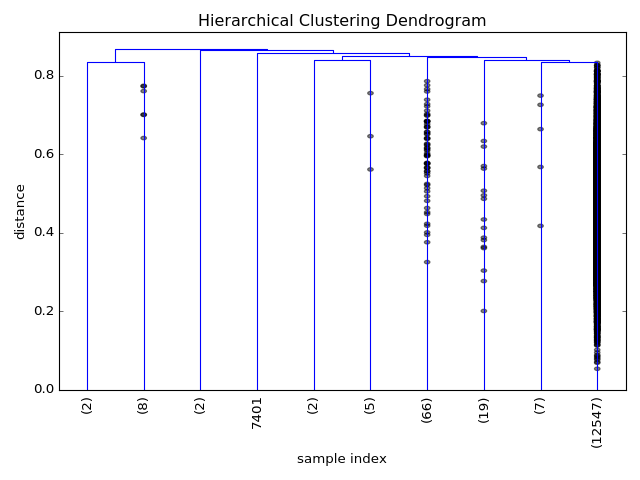

In [47]:
plt.figure()
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    spcluster,
    truncate_mode='lastp',
    p=10,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    show_contracted=True,
)
plt.tight_layout()

In [48]:
logger.info('Computing co-occurence graph')

T=[' '.join(w) for w in sentences_nouns]

Sep-10-2016 19:54:34 Computing co-occurence graph


In [49]:
logger.info(len(T))

Sep-10-2016 19:54:36 52301


In [50]:
##Co-occurence matrix
cv=CountVectorizer(token_pattern=u'(?u)\\b([^\\s]+)')
bow_matrix = cv.fit_transform(T)
id2word={}
for key, value in cv.vocabulary_.items():
    id2word[value]=key

ids=[]
for key,value in cv.vocabulary_.iteritems():
    if key in model_comb_vocab:
        ids.append(value)

sort_ids=sorted(ids)
bow_reduced=bow_matrix[:,sort_ids]
normalized = TfidfTransformer().fit_transform(bow_reduced)
similarity_graph_reduced=bow_reduced.T * bow_reduced

In [51]:
##Depth-rank weighting of edges, weight of edge i,j=cosine of angle between them
logger.info('Computing degree')
m,n=similarity_graph_reduced.shape

cx=similarity_graph_reduced.tocoo()
keyz=[id2word[sort_ids[w]] for w in xrange(len(sort_ids))]
data=[]
ro=[]
co=[]
for i,j,v in itertools.izip(cx.row, cx.col, cx.data):
    if v>0 and i!=j:
        value=1
        if value>0:
            ro.append(i)
            co.append(j)
            data.append(value)

SS=sp.sparse.coo_matrix((data, (ro, co)), shape=(m,n))
SP_full=SS.tocsc()
id_word={w:id2word[sort_ids[w]] for w in xrange(len(sort_ids))}
word_id={value:key for key,value in id_word.items()}

Sep-10-2016 19:54:52 Computing degree


In [52]:
logger.info('Computing metrics')
#compute metrics
degsum=SP_full.sum(axis=1)
deg={}
for x in xrange(len(sort_ids)):
    deg[id2word[sort_ids[x]]]=int(degsum[x])

max_deg=max(deg.values())
max_depth=max(depth.values())

temp_deg_mod={w:np.log(1+deg[w])/np.log(1+max_deg) for w in deg.iterkeys()}
alpha=np.log(0.5)/np.log(np.median(temp_deg_mod.values()))
deg_mod={key:value**alpha for key, value in temp_deg_mod.iteritems()}

temp={key:value*1./max_depth for key, value in depth.iteritems()}
alpha=np.log(0.5)/np.log(np.median(temp.values()))
depth_mod={key:value**alpha for key, value in temp.iteritems()}

temp={key:deg_mod[key]*depth_mod[key] for key in depth_mod.iterkeys()}
max_metric=np.max(temp.values())
metric={key:value*1./max_metric for key,value in temp.iteritems()}

Sep-10-2016 19:54:54 Computing metrics


In [53]:
logger.info('max_deg = %s, max_depth = %s',max_deg, max_depth)

Sep-10-2016 19:55:06 max_deg = 3350, max_depth = 142


In [72]:
##Kmeans
NUM_TOPICS = 100
K=NUM_TOPICS
kmeans=KMeans(n_clusters=K)
kmeans.fit([w for w in data_d2v])
kmeans_label={word_d2v[x]:kmeans.labels_[x] for x in xrange(len(word_d2v))}

kmeans_label_ranked={}

topic=[[] for i in xrange(K)]
clust_depth=[[] for i in xrange(K)]
for i in xrange(K):
    topic[i]=[word_d2v[x] for x in xrange(len(word_d2v)) if kmeans.labels_[x]==i]
    temp_score=[metric[w] for w in topic[i]]
    clust_depth[i]=-np.mean(sorted(temp_score,reverse=True)[:])#int(np.sqrt(len(topic[i])))])
index=np.argsort(clust_depth)
for num,i in enumerate(xrange(K)):
    for w in topic[index[i]]:
        kmeans_label_ranked[w]=i

In [73]:
logger.info('Done...Generating output')
lister=[]
to_show=K
to_show_words=20 #the maximum number of words of each type to display
for i in xrange(to_show):
    top=topic[index[i]]
    sort_top=[w[0] for w in sorted([[w,metric[w]] for w in top],key=itemgetter(1),reverse=True)]
    lister.append(['Topic %d' %(i+1)]+sort_top[:to_show_words])

max_len=max([len(w) for w in lister])
new_list=[]
for list_el in lister:
    new_list.append(list_el + [''] * (max_len - len(list_el)))
Topics=list(itertools.izip_longest(*new_list))
#X.insert(len(X),[-int(clust_depth[index[w]]*100)*1./100 for w in xrange(K)])
sorted_words=[w[0] for w in sorted(metric.items(),key=itemgetter(1),reverse=True)][:to_show_words]

Sep-10-2016 20:01:38 Done...Generating output


In [74]:
score_words = sorted_words
deep_words = [w[0] for w in depth.most_common(to_show_words)]
filer = 'wiki_simple.txt'
outfile_topics = data_directory + filer.split('.')[0] + '_topics.csv'
outfile_score = data_directory + filer.split('.')[0] + '_score.csv'
outfile_depth = data_directory + filer.split('.')[0] + '_depth.csv'
b = open(outfile_topics, 'wb')
a = csv.writer(b)
a.writerows(Topics)
b = open(outfile_score, 'wb')
a = csv.writer(b)
a.writerows([[w] for w in score_words])
b = open(outfile_depth, 'wb')
a = csv.writer(b)
a.writerows([[w] for w in deep_words])

In [75]:
score_words[0:10]

[u'enron',
 u'development',
 u'process',
 u'strategy',
 u'system',
 u'data',
 u'resources',
 u'systems',
 u'software',
 u'services']

In [76]:
pd.options.display.max_columns = 999

In [77]:
df = pd.DataFrame(Topics[1:],columns=Topics[0])
print 'Number of Topics = %s'% K
df

Number of Topics = 100


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30,Topic 31,Topic 32,Topic 33,Topic 34,Topic 35,Topic 36,Topic 37,Topic 38,Topic 39,Topic 40,Topic 41,Topic 42,Topic 43,Topic 44,Topic 45,Topic 46,Topic 47,Topic 48,Topic 49,Topic 50,Topic 51,Topic 52,Topic 53,Topic 54,Topic 55,Topic 56,Topic 57,Topic 58,Topic 59,Topic 60,Topic 61,Topic 62,Topic 63,Topic 64,Topic 65,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74,Topic 75,Topic 76,Topic 77,Topic 78,Topic 79,Topic 80,Topic 81,Topic 82,Topic 83,Topic 84,Topic 85,Topic 86,Topic 87,Topic 88,Topic 89,Topic 90,Topic 91,Topic 92,Topic 93,Topic 94,Topic 95,Topic 96,Topic 97,Topic 98,Topic 99,Topic 100
0,lorain,benefits,development,system,increase,mclarty,resources,benefit,process,law,demby,parkman,ibm,houston_tx,efficiency,yoav,mail,software,court,knowledge,kouchner,service,bills,problems,organization,houston,congress,matters,reform,texas,manager,solution,enron,school,contractor,experience,facilitates,things,fact,company,discontinuities,cfos,garwood,time,week,moves,government,post,head,communities,crisis,springs,issue,msn,degradation,download,target,term,people,reason,threat,paper,cambridge,drive,tips,street,success,calls,air,weta,targets,conditions,children,points,briefs,ordination,food,block,series,lukasiewicz,yesterday,road,choice,game,johnson,countries,mackey,tindall,madera,durnan,birdsong,peacekeeping,michaels,flicker,worlds,vajpayee,london,tion,arnaud,trai
1,wortham,investment,strategy,data,rates,waldron,policy,support,response,standards,raissa,canoga,cowen,phoenix_az,utilisation,stockdale,message,computer,decision,problem,europes,access,synergies,effects,agency,california,bush_administration,decision_makers,policies,pennsylvania,report,oil,caperton,university,counsel,thoughts,output,talk,individuals,companies,fluctuations,cera,hendricks,number,morning,handle,approval,october,move,parts,peacekeepers,calaveras,articles,online,mechanism,free_download,size,comparison,officials,dictate,force,talent,cumbria,vehicle,mouth,park,estefan,exposes,express,channel,blasts,water,friend,challenge,shoes,god,infusion,stoppers,dear_mr,dollinger,love,plain,recognition,ream,stevenson,america,james,jolene,francisco,cressman,boyce,middle_east,beat,pack,gods,sitara,royal,dtd,rtf,yen
2,smith,funds,strategies,systems,costs,baker,fund,help,changes,requirements,podell,westford,aapl,dallas,cfls,hassett,fax,hardware,crime,ideas,coretta,web,liquidity,disease,commission,avenue,election,participation,governments,charleston,expectations,gas,white_house,students,affairs,commitment,modems,feel,evidence,executives,interaction,rff,winston,today,month,speed,agreement,cancellation,side,capital,peace_negotiations,butte,text,yahoo,cell,audio,style,terms,workers,intervenes,war,ads,bolton,vehicles,eyes,building,roll,urges,airlines,radio,danger,range,partner,texaco,suit,prayer,afternoon_tea,boards,voice,krauss,dear,sepulveda,honors,games,wilson,country,reid,joanne,hernando,byers,music,syria,edge,intruders,fallout,rajiv,companys,amrane,cazeneuve,tham
3,gunnell,tax,experts,services,cost,bowman,business,balance,procedures,guidelines,treetop,morrisville,intc,boston,energy,greenburg,phone,server,corruption,idea,gaffe,survey,retrofits,drug,associates,sonoma,campaign,agenda,human_rights,massachusetts,dynegy,petroleum,attorney,education,office,mind,redundancy,learn,others,corporation,function,perce,gaylord,course,dinner,step,constitution,retirement,cut,areas,peace_talks,mendocino,book,com,coa,version,width,definition,refugees,cease,forces,advertising,oxford,cars,gouging,street_nw,vowles,reveals,flight,television,strike,margins,child,women,cap,teaches,chips,levers,role,quandt,hello,separates,awards,career,richie,european_countries,meldrum,jennie,rancho,bauman,hahn,iraq,battleground,quacks,ents,